In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time
import pickle
from imp import reload
from os.path import join

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from data_loader import DataLoader
import medim
reload(medim);

In [2]:
raw_path = '/home/mount/neuro-t01-hdd/Brats2017/data/raw/'

data_loader = DataLoader(raw_path)
patients = data_loader.patients

n_classes = 3

In [3]:
processed_path = '/mount/export/Brats2017/data/processed'
mscans = []
msegms = []

for patient in tqdm(patients):
    filename = join(processed_path, patient)
    
    mscans.append(np.load(filename+'_mscan.npy'))
    msegms.append(np.load(filename+'_segmentation.npy'))

100%|██████████| 285/285 [00:45<00:00,  5.35it/s]


In [4]:
n_splits = 5

cv = KFold(n_splits, shuffle=True, random_state=42)
tr, test = next(cv.split(mscans))

def extract(l, idx):
    return [l[i] for i in idx]

mscans_tr, mscans_test = extract(mscans, tr), extract(mscans, test)
msegms_tr, msegms_test = extract(msegms, tr), extract(msegms, test)

In [5]:
n_splits = 40

cv = KFold(n_splits, shuffle=True, random_state=21)
train, val = next(cv.split(mscans_tr))

def extract(l, idx):
    return [l[i] for i in idx]

mscans_train, mscans_val = extract(mscans_tr, train), extract(mscans_tr, val)
msegms_train, msegms_val = extract(msegms_tr, train), extract(msegms_tr, val)

In [6]:
print(len(mscans), len(mscans_test), len(mscans_train), len(mscans_val))

285 57 222 6


In [7]:
print(mscans[0].shape)

(4, 140, 172, 145)


In [8]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = kernel_size - 1
        
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, bias=False)
        
    def forward(self, x):
        residual = torch.cat([x, Variable(torch.zeros(x.size())).cuda()], dim=1)
        size = residual.size()
        residual = residual.clone()
        residual = residual[:,:self.out_channels, self.padding:size[2]-self.padding, 
                            self.padding:size[3]-self.padding, self.padding:size[4]-self.padding]
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = out.clone() + residual
        return out

class Model(nn.Module):
    def __init__(self, block, n_chans_path1, n_chans_path2, n_chans_common_part, kernel_size, num_classes=3):
        super(Model, self).__init__()
        in_channels = 4
        #path1
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv3d(in_channels, n_chans_path1[0], kernel_size, bias=False)
        
        self.bn2 = nn.BatchNorm3d(n_chans_path1[0])
        self.conv2 = nn.Conv3d(n_chans_path1[0], n_chans_path1[1], kernel_size, bias=False)
        
        self.layer1 = block(n_chans_path1[1], n_chans_path1[2], kernel_size)
        self.layer2 = block(n_chans_path1[2], n_chans_path1[4], kernel_size)
        self.layer3 = block(n_chans_path1[4], n_chans_path1[6], kernel_size)
        
        #path2
        self.avg_pool = nn.AvgPool3d(3)
        self.bn3 = nn.BatchNorm3d(in_channels)
        self.conv3 = nn.Conv3d(in_channels, n_chans_path2[0], kernel_size, bias=False)
        
        self.bn4 = nn.BatchNorm3d(n_chans_path2[0])
        self.conv4 = nn.Conv3d(n_chans_path2[0], n_chans_path2[1], kernel_size, bias=False)
        
        self.layer4 = block(n_chans_path2[1], n_chans_path2[2], kernel_size)
        self.layer5 = block(n_chans_path2[2], n_chans_path2[4], kernel_size)
        self.layer6 = block(n_chans_path2[4], n_chans_path2[6], kernel_size)
        
        
        self.convTr = torch.nn.ConvTranspose3d(n_chans_path2[6], n_chans_path2[8], kernel_size=5, 
                                               stride=3, padding=1)
        
        self.layer7 = block(n_chans_common_part[0], n_chans_common_part[2], 1)
        
        self.conv5 = nn.Conv3d(n_chans_common_part[2], n_chans_common_part[3], 1, bias=False)
        self.bn5 = nn.BatchNorm3d(n_chans_common_part[3])
        self.s = nn.Sigmoid()
        
    def forward(self, x, x_ext):
        out_path1 = self.bn1(x)
        out_path1 = self.relu(out_path1)
        out_path1 = self.conv1(out_path1)
        out_path1 = self.bn2(out_path1)
        out_path1 = self.relu(out_path1)
        out_path1 = self.conv2(out_path1)
        out_path1 = self.layer1(out_path1)
        out_path1 = self.layer2(out_path1)
        out_path1 = self.layer3(out_path1)
        
        out_path2 = self.avg_pool(x_ext)
        out_path2 = self.bn3(out_path2)
        out_path2 = self.relu(out_path2)
        out_path2 = self.conv3(out_path2)
        out_path2 = self.bn4(out_path2)
        out_path2 = self.relu(out_path2)
        out_path2 = self.conv4(out_path2)
        out_path2 = self.layer4(out_path2)
        out_path2 = self.layer5(out_path2)
        out_path2 = self.layer6(out_path2)
        out_path2 = self.convTr(out_path2)
        
        out = torch.cat([out_path1, out_path2], dim=1)
        
        out = self.layer7(out)
        out = self.conv5(out)
        out = self.bn5(out)
        out = self.s(out)
        return out

In [9]:
kernel_size = 3
n_chans_path1 = [30, 30, 40, 40, 40, 40, 50, 50]
n_chans_path2 = [30, 30, 40, 40, 40, 40, 50, 50, 50]
n_chans_common_part = [100, 150, 150, n_classes]

patch_size_x = np.array([25, 25, 25])
patch_size_x_ext = patch_size_x + 32
patch_size_y = patch_size_x - 2*(len(n_chans_path1))

model = Model(ResidualBlock, n_chans_path1, n_chans_path2,
              n_chans_common_part, kernel_size).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [10]:
padding = (patch_size_x - patch_size_y) // 2
padding_ext = (patch_size_x_ext - patch_size_y) // 2

def min_padding(mscan, padding):
    padding = np.array([0] + list(padding))
    padding = np.repeat(padding[:, None], 2, axis=1)
    
    return np.pad(mscan, padding, mode='minimum')

In [11]:
def pred_reshape(y):
    x = y.permute(0, 2, 3, 4, 1)
    return x.contiguous().view(-1, x.size()[-1])

def loss_cross_entropy(y_pred, y_true):
    return F.cross_entropy(pred_reshape(y_pred), y_true.view(-1))

def loss_binary_entropy(y_pred, y_true):
    return F.binary_cross_entropy(y_pred, y_true)

def to_var(x, volatile=False):
    return Variable(torch.from_numpy(x), volatile=volatile).cuda()

def to_numpy(x):
    return x.cpu().data.numpy()

coeff = to_var(np.array([1, 2, 3], dtype=np.float32))
epsilon = 1e-7

def dice_loss(y_pred, target):
    y_pred = y_pred.view(*y_pred.size()[:2], -1)
    target = target.view(*target.size()[:2], -1)
    
#     s = y_pred.size()
#     e = epsilon.expand(s[0], 1, s[2])
    dice_scores = 2 * (epsilon + (y_pred * target).sum(2)) / \
                  (y_pred.sum(2) + target.sum(2) + 2 * epsilon)
        
    dice_scores = dice_scores.mean(0)
    dice_scores = dice_scores.view(-1)

    return -torch.sum(dice_scores * coeff)

def dice_score(y_pred, target):
    """Dice score for binary segmentation on 3d scan"""
    dcs = 2 * np.sum(y_pred * target) / (np.sum(y_pred) + np.sum(target))
    if np.isnan(dcs):
        return 1
    else:
        return dcs

In [12]:
def uniform_ext(mscans, msegms, *, batch_size, patch_size_x_ext, patch_size_x, patch_size_y):
    """Patch iterator with uniformed distribution over spatial dimensions"""
    assert np.all(patch_size_x % 2 == patch_size_y % 2)
    patch_size_pad = (patch_size_x - patch_size_y) // 2
    patch_size_pad_ext = (patch_size_x_ext - patch_size_y) // 2

    n = len(mscans)

    max_spatial_idy = np.array(
        [list(s.shape[1:]) for s in mscans]) - patch_size_y + 1

    x_batch_ext = np.zeros((batch_size, mscans[0].shape[0], *patch_size_x_ext), dtype=np.float32)
    x_batch = np.zeros((batch_size, mscans[0].shape[0], *patch_size_x), dtype=np.float32)
    y_batch = np.zeros((batch_size, msegms[0].shape[0], *patch_size_y), dtype=np.float32)

    while True:
        idy = np.random.randint(n, size=batch_size)
        start_idy = np.random.rand(batch_size, 3) * max_spatial_idy[idy]
        start_idy = np.int32(np.floor(start_idy))
        for i in range(batch_size):
            s = start_idy[i]
            slices = [...] + [slice(s[k], s[k] + patch_size_y[k]) for k in
                              range(3)]
            y_batch[i] = msegms[idy[i]][slices]

            s = start_idy[i] - patch_size_pad
            e = s + patch_size_x
            padding_l = [0] + [-s[i] if s[i] < 0 else 0 for i in range(s.shape[0])]
            padding_r = [0] + [-mscans[idy[i]].shape[k+1] + e[k] if e[k] >= mscans[idy[i]].shape[k+1] else 0 
                               for k in range(e.shape[0])]
            padding = list(zip(padding_l, padding_r))
            slices = [...] + [slice(max(s[k], 0), min(e[k], mscans[idy[i]].shape[k+1])) 
                              for k in range(3)]
            
            min_const = np.amin(mscans[idy[i]])
            x_batch[i] = np.pad(mscans[idy[i]][slices], padding, mode='constant', constant_values=min_const)
            
            s = start_idy[i] - patch_size_pad_ext
            e = s + patch_size_x_ext
            padding_l = [0] + [-s[i] if s[i] < 0 else 0 for i in range(s.shape[0])]
            padding_r = [0] + [-mscans[idy[i]].shape[k+1] + e[k] if e[k] >= mscans[idy[i]].shape[k+1] else 0 \
                               for k in range(e.shape[0])]
            padding = list(zip(padding_l, padding_r))
            slices = [...] + [slice(max(s[k], 0), min(e[k], mscans[idy[i]].shape[k+1])) 
                              for k in range(3)]
            
            min_const = np.amin(mscans[idy[i]])
            x_batch_ext[i] = np.pad(mscans[idy[i]][slices], padding, mode='constant', constant_values=min_const)
        yield np.array(x_batch_ext), np.array(x_batch), np.array(y_batch)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
n_epoch = 100
batch_per_epoch = 40
batch_size = 100

loss_train = []
loss_val = []
dsc_val = []

for epoch in range(n_epoch):
    train_iter = uniform_ext(
        mscans_train, msegms_train, batch_size=batch_size, patch_size_x_ext=patch_size_x_ext,
        patch_size_x=patch_size_x, patch_size_y=patch_size_y, 
    )
    
    start_train = time.time()
    
    model.train()
    losses = []
    weights = []
    for _ in tqdm(range(batch_per_epoch)):
        x_batch_ext, x_batch, y_batch = next(train_iter)

        y_pred = model(to_var(x_batch), to_var(x_batch_ext))

        optimizer.zero_grad()
        loss = loss_binary_entropy(y_pred, to_var(y_batch))
        
        loss.backward()
        optimizer.step()

        losses.append(to_numpy(loss))
        weights.append(len(x_batch))
            
    train_loss = np.average(np.array(losses).flatten(), weights=weights)
    #train_acc = np.average(np.array(accs).flatten(), weights=weights)
    
    end_train = time.time()
    
    start_val = time.time()
    
    model.eval()
    losses = []
    dices = []
    for mscan, segm in tqdm(zip(mscans_val, msegms_val)):
        
        size = np.array(mscan.shape[1:])
        x_ext_size = size + 2*padding_ext
        x_ext_size = (x_ext_size // 6 ) * 6
        size = x_ext_size - 2*padding_ext
        
        mscan = mscan[:, :size[0], :size[1], :size[2]]
        segm = segm[:, :size[0], :size[1], :size[2]]
        
        x_batch_ext = min_padding(mscan, padding_ext)[None, :]
        x_batch = min_padding(mscan, padding)[None, :]
        y_batch = np.array(segm[None, :], dtype=np.float32)
        
        s = y_batch.shape[-1] // 2
        half_x_1 = x_batch[..., :s+2*padding[-1]]
        half_x_2 = x_batch[..., s:]
        
        half_x_ext_1 = x_batch_ext[..., :s+2*padding_ext[-1]]
        half_x_ext_2 = x_batch_ext[..., s:]
        
        half_y_1 = y_batch[..., :s]
        half_y_2 = y_batch[..., s:]
        
        y_pred = model(to_var(half_x_1, volatile=True), to_var(half_x_ext_1, volatile=True))
        loss = F.binary_cross_entropy(y_pred, to_var(half_y_1))
        losses.append(to_numpy(loss))
        y_pred1 = to_numpy(y_pred)
        
        y_pred = model(to_var(half_x_2, volatile=True), to_var(half_x_ext_2, volatile=True))
        loss = F.binary_cross_entropy(y_pred, to_var(half_y_2))
        losses.append(to_numpy(loss))
        y_pred2 = to_numpy(y_pred)
    
        y_pred = np.concatenate((y_pred1, y_pred2), axis=4)
        
        dices.append([dice_score(y_pred[0, k] > 0.5, y_batch[0, k]) for k in range(n_classes)])
        losses.append(to_numpy(loss))
    
    end_val = time.time()
    
    val_loss = np.mean(np.array(losses).flatten())
    val_dices = np.mean(np.array(dices), axis=0)
    
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    dsc_val.append(val_dices)
    
    print('Epoch {}'.format(epoch))
    print('Train:', train_loss)
    print('Val  :', val_loss, val_dices)
    print('Time :', end_train - start_train, end_val - start_val)
    print('\n')

100%|██████████| 40/40 [01:11<00:00,  1.77s/it]
4it [00:18,  4.72s/it]/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars
6it [00:28,  4.92s/it]
  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0
Train: 0.0273696730379
Val  : 0.0230069 [ 0.77970669  0.50798962  0.4366126 ]
Time : 71.4783148765564 28.89525318145752




100%|██████████| 40/40 [01:09<00:00,  1.74s/it]
6it [00:28,  4.88s/it]
  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1
Train: 0.0254517999012
Val  : 0.0233917 [ 0.77741008  0.44962648  0.40410545]
Time : 69.84452414512634 28.648496866226196




100%|██████████| 40/40 [01:09<00:00,  1.74s/it]
6it [00:28,  4.87s/it]
  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2
Train: 0.0276435968233
Val  : 0.0230914 [ 0.7787553   0.47743197  0.39411342]
Time : 69.76012659072876 28.537301063537598




100%|██████████| 40/40 [01:09<00:00,  1.75s/it]
6it [00:28,  4.87s/it]
  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3
Train: 0.0294483793899
Val  : 0.0234536 [ 0.77709202  0.43174551  0.38232906]
Time : 69.84876680374146 28.485759973526




100%|██████████| 40/40 [01:09<00:00,  1.74s/it]
0it [00:00, ?it/s]


KeyboardInterrupt: 

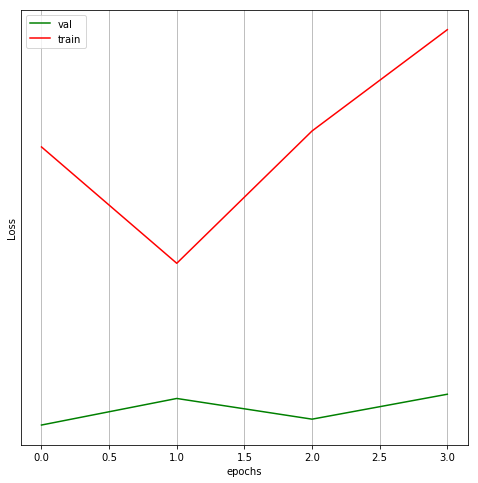

In [19]:
plt.figure(figsize=(8,8))
plt.plot(loss_val, 'g', label='val')
plt.plot(loss_train, 'r', label='train')
plt.yscale('log')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.grid()

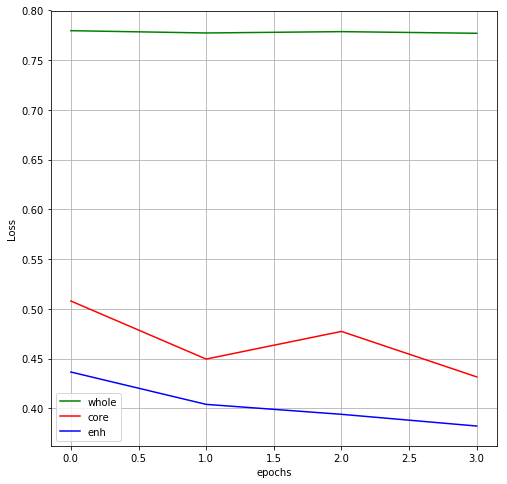

In [20]:
plt.figure(figsize=(8,8))
plt.plot(np.array(dsc_val)[:, 0], 'g', label='whole')
plt.plot(np.array(dsc_val)[:, 1], 'r', label='core')
plt.plot(np.array(dsc_val)[:, 2], 'b', label='enh')
#plt.yscale('log')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.grid()

In [21]:
model.eval()

Model (
  (bn1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (conv1): Conv3d(4, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  (bn2): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv3d(30, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  (layer1): ResidualBlock (
    (bn1): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv1): Conv3d(30, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  )
  (layer2): ResidualBlock (
    (bn1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv1): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1),

In [22]:
y_predicted = []
dcs_whole = []
dcs_core = []
dcs_enh = []

for mscan, segm in tqdm(zip(mscans_val, msegms_val)):
    
    size = np.array(mscan.shape[1:])
    x_ext_size = size + 2*padding_ext
    x_ext_size = (x_ext_size // 6 ) * 6
    size = x_ext_size - 2*padding_ext

    mscan = mscan[:, :size[0], :size[1], :size[2]]
    segm = segm[:, :size[0], :size[1], :size[2]]

    x_batch_ext = min_padding(mscan, padding_ext)[None, :]
    x_batch = min_padding(mscan, padding)[None, :]
    y_batch = np.array(segm[None, :], dtype=np.float32)

    s = y_batch.shape[-1] // 2
    half_x_1 = x_batch[..., :s+2*padding[-1]]
    half_x_2 = x_batch[..., s:]

    half_x_ext_1 = x_batch_ext[..., :s+2*padding_ext[-1]]
    half_x_ext_2 = x_batch_ext[..., s:]

    half_y_1 = y_batch[..., :s]
    half_y_2 = y_batch[..., s:]

    y_pred = model(to_var(half_x_1, volatile=True), to_var(half_x_ext_1, volatile=True))
    loss = F.binary_cross_entropy(y_pred, to_var(half_y_1))
    losses.append(to_numpy(loss))
    y_pred1 = to_numpy(y_pred)

    y_pred = model(to_var(half_x_2, volatile=True), to_var(half_x_ext_2, volatile=True))
    loss = F.binary_cross_entropy(y_pred, to_var(half_y_2))
    losses.append(to_numpy(loss))
    y_pred2 = to_numpy(y_pred)

    y_pred = np.concatenate((y_pred1, y_pred2), axis=4)

    #y_predicted.append(y_pred[0])
    dcs_whole.append([dice_score(y_pred[0, 0] > p, y_batch[0, 0]) for p in np.linspace(0.01, 1, 100)])
    dcs_core.append([dice_score(y_pred[0, 1] > p, y_batch[0, 1]) for p in np.linspace(0.01, 1, 100)])
    dcs_enh.append([dice_score(y_pred[0, 2] > p, y_batch[0, 2]) for p in np.linspace(0.01, 1, 100)])

4it [00:28,  7.32s/it]/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars
6it [00:44,  7.47s/it]


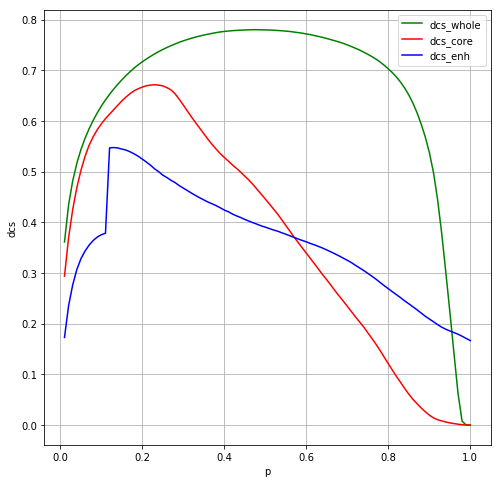

In [23]:
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0.01, 1, 100), np.mean(np.array(dcs_whole), axis=0), 'g', label='dcs_whole')
plt.plot(np.linspace(0.01, 1, 100), np.mean(np.array(dcs_core), axis=0), 'r', label='dcs_core')
plt.plot(np.linspace(0.01, 1, 100), np.mean(np.array(dcs_enh), axis=0), 'b', label='dcs_enh')
plt.legend()
plt.ylabel('dcs')
plt.xlabel('p')
plt.grid()

In [24]:
p = []
p.append(np.linspace(0.01, 1, 100)[np.argmax(np.mean(np.array(dcs_whole), axis=0))])
p.append(np.linspace(0.01, 1, 100)[np.argmax(np.mean(np.array(dcs_core), axis=0))])
p.append(np.linspace(0.01, 1, 100)[np.argmax(np.mean(np.array(dcs_enh), axis=0))])
p

[0.47000000000000003, 0.23000000000000001, 0.13]

In [25]:
y_predicted = []
dcs_whole = []
dcs_core = []
dcs_enh = []

for mscan, segm in tqdm(zip(mscans_test, msegms_test)):
    
    size = np.array(mscan.shape[1:])
    x_ext_size = size + 2*padding_ext
    x_ext_size = (x_ext_size // 6 ) * 6
    size = x_ext_size - 2*padding_ext

    mscan = mscan[:, :size[0], :size[1], :size[2]]
    segm = segm[:, :size[0], :size[1], :size[2]]

    x_batch_ext = min_padding(mscan, padding_ext)[None, :]
    x_batch = min_padding(mscan, padding)[None, :]
    y_batch = np.array(segm[None, :], dtype=np.float32)

    s = y_batch.shape[-1] // 2
    half_x_1 = x_batch[..., :s+2*padding[-1]]
    half_x_2 = x_batch[..., s:]

    half_x_ext_1 = x_batch_ext[..., :s+2*padding_ext[-1]]
    half_x_ext_2 = x_batch_ext[..., s:]

    half_y_1 = y_batch[..., :s]
    half_y_2 = y_batch[..., s:]

    y_pred = model(to_var(half_x_1, volatile=True), to_var(half_x_ext_1, volatile=True))
    loss = F.binary_cross_entropy(y_pred, to_var(half_y_1))
    losses.append(to_numpy(loss))
    y_pred1 = to_numpy(y_pred)

    y_pred = model(to_var(half_x_2, volatile=True), to_var(half_x_ext_2, volatile=True))
    loss = F.binary_cross_entropy(y_pred, to_var(half_y_2))
    losses.append(to_numpy(loss))
    y_pred2 = to_numpy(y_pred)

    y_pred = np.concatenate((y_pred1, y_pred2), axis=4)

    #y_predicted.append(y_pred[0])
    dcs_whole.append(dice_score(y_pred[0, 0] > p[0], y_batch[0, 0]))
    dcs_core.append(dice_score(y_pred[0, 1] > p[1], y_batch[0, 1]))
    dcs_enh.append(dice_score(y_pred[0, 2] > p[2], y_batch[0, 2]))

47it [03:51,  4.81s/it]/home/mount/neuro-t01-ssd/home/krivov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars
57it [04:40,  4.95s/it]


In [26]:
print(np.mean(np.array(dcs_whole)), np.mean(np.array(dcs_core)), np.mean(np.array(dcs_enh)))

0.771397135646 0.557869313902 0.466980482547


In [1]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

i = 1
k = 40

cmap = cm.Blues

ax[0, 0].imshow(y_predicted[i][0, ..., k], cmap=cmap)
#plt.colorbar()
#plt.show()
ax[0, 1].imshow(msegms_val[i][0, ..., k], cmap=cmap)
ax[1, 0].imshow(mscans_val[i][3, ..., k], cmap=cmap)
plt.tight_layout()
plt.show()
#plt.colorbar()
#plt.show()

NameError: name 'plt' is not defined